In [1]:
import numpy as np
from stan.helpers import StanModel_cache
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from collections import OrderedDict
import seaborn as sns

%matplotlib inline

In [2]:
def model(model: str, priors_dict) -> "StanModel": 
    '''e.g. priors_dict={"mu":"normal(0,1)", "sigma":"gamma(3,1)"}'''
    file = "stan/os_{}.stan".format(model)
    with open(file) as f:
        code = f.read()
    with open("stan/functions.stan") as f:
        functions = f.read()
        
    stan_code = functions + code
    return StanModel_cache(model_code=stan_code)


model_names = ['weibull', 'lognormal', 'gamma', 
               'inv_gamma', 'frechet', 'chi_square',
               'exponential']
models = OrderedDict()
for name in model_names:
    models[name] = model(name, {})

Using cached StanModel
Using cached StanModel
Using cached StanModel
Using cached StanModel
Using cached StanModel
Using cached StanModel
Using cached StanModel


In [3]:
#helper functions for prettier prints

def emp_print(lis: list, c:'color', i=None):
    """prints a list with one emphasised number"""
    tmp = []
    for j, element in enumerate(lis):
        elem = '{:10.3f}'.format(element)
        if i is None:
            tmp.append(colored(elem, c))
        else:
            tmp.append(elem if i!=j else colored(elem, c))
    print(*tmp)
    
    
float_to_str = lambda fl, sign=False: '{:+.1f}'.format(fl) if sign \
                                        else '{:.1f}'.format(fl) 
    
def to_tex_field(num, p, m):
    """number, plus, minus"""
    return '${}^{{\ {}}}_{{\ {}}}$'.format(
        float_to_str(num),
        float_to_str(p, sign=True),
        float_to_str(m, sign=True)
    )

In [4]:
data = pd.read_csv('salary_data.csv', index_col=0)
data

,N,25,50,75
UK,17645,14897,21136,30151
EL,12918,4930,7500,11000
ES,19177,8803,13681,20413
FR,21325,16185,21713,29008
IT,24969,10699,16247,22944
SE,11635,17794,25164,33365
LU,10292,23964,33818,48692
NL,12748,16879,22733,30327


In [5]:
tmp = ['25', '50', '75']
data_normalized = data.copy()
data_normalized.loc[:, tmp] = (data_normalized.loc[:, tmp].T/
                               data_normalized.loc[:, '50']).T
data_normalized

,N,25,50,75
UK,17645,0.704816,1.0,1.426523
EL,12918,0.657333,1.0,1.466667
ES,19177,0.643447,1.0,1.492069
FR,21325,0.745406,1.0,1.335974
IT,24969,0.658522,1.0,1.412199
SE,11635,0.707121,1.0,1.325902
LU,10292,0.708617,1.0,1.439825
NL,12748,0.742489,1.0,1.334052


In [6]:
print(*['{:>10s}'.format(x_) for x_ in models.keys()])
df_lp = pd.DataFrame(index=data.index, columns=models.keys())
best_fit = OrderedDict()
samples = OrderedDict()
p_up_down = [95, 5]   # upper and lower 95 and 5 quantile from log_likelihood estimates

for ind in data_normalized.index:
    N = data_normalized.loc[ind, 'N']
    q = np.array([0.25, 0.5, 0.75])
    X = [data_normalized.loc[ind, q_] for q_ in ['25', '50', '75']]

    data_dict = {'N':N, 'M':len(q), 'q':q, 'X':X}
    samples[ind] = OrderedDict()
    lp, lp_up, lp_down = [], [], []
    
    for model_name, stan_model in models.items():
        sam = stan_model.sampling(data_dict)  
        samples[ind][model_name] = sam
        lp_mean = sam.extract(['log_prob'])['log_prob'].mean()
        up, down = np.percentile(sam.extract(['log_prob'])['log_prob'], 
                                       p_up_down)
        lp.append(lp_mean)
        lp_up.append(up)
        lp_down.append(down)
        df_lp.loc[ind, model_name] = to_tex_field(lp_mean, 
                                                  up-lp_mean,
                                                  down-lp_mean)
        
    print(ind)
    emp_print(lp, 'green', np.argmax(lp))
    best_fit[ind] = list(models.keys())[np.argmax(lp)]
    
#print dataframe
display(df_lp)

   weibull  lognormal      gamma  inv_gamma    frechet chi_square exponential


/home/nirwan/.local/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


UK
   -62.817     12.133     -8.073      0.425    -45.643  -3582.747  -2641.134
EL
    -6.934      4.338     10.219    -31.450    -81.068  -2063.902  -1416.385
ES
   -13.364     -0.201     10.036    -58.809   -130.306  -2776.183  -1854.619
FR
   -57.686     12.952      3.567     -4.378    -76.752  -5847.586  -4554.293
IT
     9.090    -48.951      5.276   -155.293   -289.994  -4500.285  -3139.818
SE
    11.401    -21.192      3.875    -62.920   -138.689  -2910.801  -2191.059
LU
   -47.707      9.331     -9.285      9.134    -10.923  -2062.259  -1524.115
NL
   -23.337     11.562      8.843     -1.886    -49.366  -3473.820  -2698.112


,weibull,lognormal,gamma,inv_gamma,frechet,chi_square,exponential
UK,$-62.8^{\ +1.0}_{\ -2.0}$,$12.1^{\ +0.9}_{\ -1.9}$,$-8.1^{\ +0.9}_{\ -2.0}$,$0.4^{\ +1.0}_{\ -2.1}$,$-45.6^{\ +0.9}_{\ -2.0}$,$-3582.7^{\ +0.5}_{\ -1.4}$,$-2641.1^{\ +0.5}_{\ -1.4}$
EL,$-6.9^{\ +0.9}_{\ -1.9}$,$4.3^{\ +0.9}_{\ -1.9}$,$10.2^{\ +1.0}_{\ -2.0}$,$-31.4^{\ +0.9}_{\ -1.9}$,$-81.1^{\ +1.0}_{\ -2.0}$,$-2063.9^{\ +0.5}_{\ -1.4}$,$-1416.4^{\ +0.5}_{\ -1.4}$
ES,$-13.4^{\ +1.0}_{\ -2.0}$,$-0.2^{\ +1.0}_{\ -2.0}$,$10.0^{\ +0.9}_{\ -2.2}$,$-58.8^{\ +0.9}_{\ -1.9}$,$-130.3^{\ +0.9}_{\ -2.1}$,$-2776.2^{\ +0.5}_{\ -1.4}$,$-1854.6^{\ +0.5}_{\ -1.4}$
FR,$-57.7^{\ +1.0}_{\ -2.0}$,$13.0^{\ +1.0}_{\ -2.0}$,$3.6^{\ +1.0}_{\ -1.9}$,$-4.4^{\ +1.0}_{\ -2.1}$,$-76.8^{\ +0.9}_{\ -1.9}$,$-5847.6^{\ +0.5}_{\ -1.4}$,$-4554.3^{\ +0.5}_{\ -1.5}$
IT,$9.1^{\ +1.0}_{\ -2.0}$,$-49.0^{\ +1.0}_{\ -2.0}$,$5.3^{\ +0.9}_{\ -2.0}$,$-155.3^{\ +1.0}_{\ -2.1}$,$-290.0^{\ +1.0}_{\ -2.0}$,$-4500.3^{\ +0.5}_{\ -1.3}$,$-3139.8^{\ +0.5}_{\ -1.5}$
SE,$11.4^{\ +1.0}_{\ -2.0}$,$-21.2^{\ +1.0}_{\ -2.1}$,$3.9^{\ +1.0}_{\ -1.9}$,$-62.9^{\ +0.9}_{\ -1.8}$,$-138.7^{\ +1.0}_{\ -2.0}$,$-2910.8^{\ +0.5}_{\ -1.4}$,$-2191.1^{\ +0.5}_{\ -1.4}$
LU,$-47.7^{\ +1.0}_{\ -2.0}$,$9.3^{\ +0.9}_{\ -2.0}$,$-9.3^{\ +1.0}_{\ -2.0}$,$9.1^{\ +0.9}_{\ -2.1}$,$-10.9^{\ +1.0}_{\ -2.1}$,$-2062.3^{\ +0.5}_{\ -1.4}$,$-1524.1^{\ +0.5}_{\ -1.5}$
NL,$-23.3^{\ +1.0}_{\ -2.1}$,$11.6^{\ +1.0}_{\ -2.1}$,$8.8^{\ +1.0}_{\ -2.2}$,$-1.9^{\ +1.0}_{\ -1.9}$,$-49.4^{\ +1.0}_{\ -2.0}$,$-3473.8^{\ +0.5}_{\ -1.4}$,$-2698.1^{\ +0.5}_{\ -1.3}$


In [7]:
df_predictive_dist = pd.DataFrame(index=data.index, columns=list(range(4000)))
for i, ind in enumerate(data.index):
    sample = samples[ind][best_fit[ind]]
    df_predictive_dist.loc[ind,:] = \
        sample.extract('predictive_dist')['predictive_dist']*data.loc[ind, '50']

/home/nirwan/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


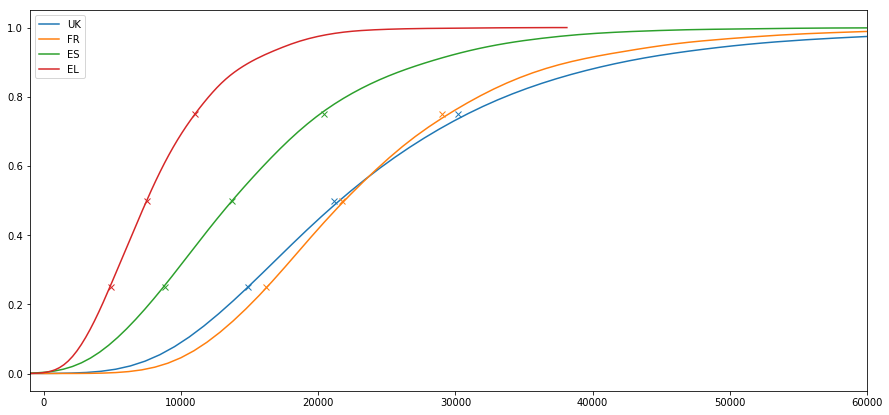

In [8]:
colors = sns.color_palette()
fig, ax = plt.subplots(1,1,figsize=(15,7))
for i, ind in enumerate(['UK', 'FR', 'ES', 'EL']):
    sns.kdeplot(df_predictive_dist.loc[ind,:], cumulative=True,
                ax=ax, label=ind, color=colors[i])
    ax.set_xlim([-1000, 60000])
    plt.plot(data.loc[ind, ['25', '50', '75']].values,
             [0.25, 0.5, 0.75], 'x', c=colors[i])
    #[ax.axhline(x, c='black', alpha=0.1) for x in [0.25, 0.5, 0.75]]

In [9]:
qs = [25, 50, 75]
quant_f = lambda pred_dist, qs: pd.Series(np.percentile(pred_dist, qs), index=qs)
print('predicted quantiles by the predictive distribution')
display(df_predictive_dist.apply(lambda pred_dist: quant_f(pred_dist, qs), axis=1))
print('')
print('99% quantile')
display(df_predictive_dist.apply(lambda pred_dist: quant_f(pred_dist, [99]), axis=1))

predicted quantiles by the predictive distribution


,25,50,75
UK,14998.031981,21488.255606,30612.455474
EL,4833.795018,7473.002940,10972.048724
ES,8839.825660,13615.795108,19932.314003
FR,16418.367234,21794.695327,29470.349814
IT,10809.997191,16407.295083,23012.647453
SE,18225.899002,25478.254827,33313.227702
LU,24066.072564,33818.559205,48341.341827
NL,17071.452089,22917.413614,30600.065582



99% quantile


,99
UK,75066.744546
EL,22472.656197
ES,43982.826938
FR,60247.411248
IT,40320.143099
SE,54986.291418
LU,112344.877997
NL,62623.324441


## $X_{observed}$ vs. $X_{pred}$ for UK

In [10]:
from scipy.stats import weibull_min
from scipy.stats import lognorm
from scipy.stats import gamma
from scipy.stats import invgamma
#from scipy.stats import frechet_l

In [11]:
%%time

def F_inv(theta, q, model_name): 
    ret = 0
    if model_name=='weibull':
        ret = weibull_min(c=theta[0], scale=theta[1]).ppf(q)
    elif model_name=='lognormal':
        ret = lognorm(s=theta[1], scale=np.exp(theta[0])).ppf(q)
    elif model_name=='gamma':
        ret = gamma(a=theta[0], scale=1/theta[1]).ppf(q)
    elif model_name=='inv_gamma':
        ret = invgamma(a=theta[0], scale=theta[1]).ppf(q)
    return ret
    
    
def get_quantiles(F_inv:"inverse cdf", theta, q, model_name):
    return list(map(lambda q_: F_inv(theta, q_, model_name), q))


ind = 'UK'
param_names_dict = {
    'weibull': ['shape', 'scale'],
    'lognormal': ['mu', 'sigma'],
    'gamma': ['shape', 'rate'],
    'inv_gamma': ['shape', 'scale'],
}

N = data_normalized.loc[ind, 'N']
q = np.array([0.25, 0.5, 0.75])
X = np.array([data_normalized.loc[ind, q_] for q_ in ['25', '50', '75']])
data_dict = {'N':N, 'M':len(q), 'q':q, 'X':X}

X_preds = OrderedDict() #prediction for observed quantiles
X_preds_unknown_q = OrderedDict() #prediciton for unobserved quantiles
q_unknown = np.array([0.99, 0.9])
for model_name, param_names in param_names_dict.items():
    stan_samples = models[model_name].sampling(data_dict) 
    thetas = np.array([stan_samples.extract(p)[p] for p in param_names])
    X_preds[model_name] = np.array([get_quantiles(F_inv, theta, q, model_name) 
                                    for theta in thetas.T])*data.loc[ind, '50']
    X_preds_unknown_q[model_name] = np.array([get_quantiles(F_inv, theta, q_unknown, model_name) 
                                    for theta in thetas.T])*data.loc[ind, '50']

CPU times: user 50.9 s, sys: 180 ms, total: 51 s
Wall time: 52 s


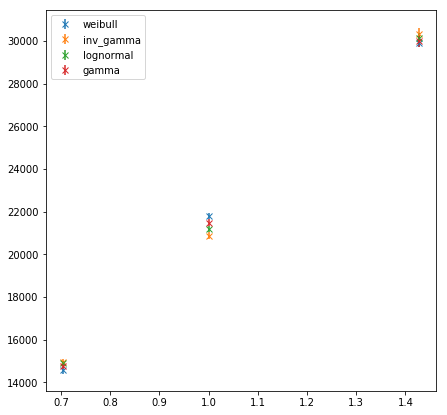

In [12]:
def plot_X_Xpred(X: "array M", X_pred:"array #samples x M", ax, model_name=None):
    low, mid, high = np.percentile(X_pred, [5, 50, 95], axis=0)
    yerr = (mid-low, high-mid)
    ax.errorbar(X, mid, yerr=yerr, marker="x", ls="", label=model_name)
    

fig, ax = plt.subplots(figsize=(7,7))

for i, (model_name, X_pred) in enumerate(X_preds.items()):
    plot_X_Xpred(X, X_pred, ax, model_name=model_name)
min_max = ax.get_ylim()
#ax.plot(min_max, min_max, c="black", alpha=0.2)
ax.legend()
plt.show()

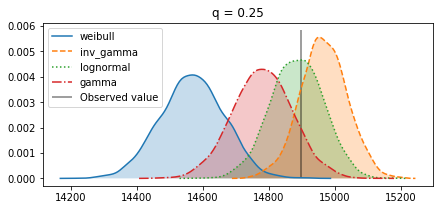

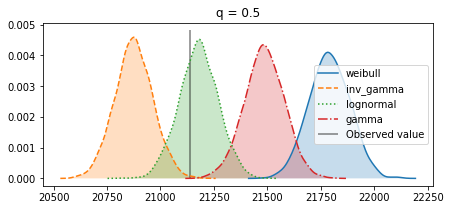

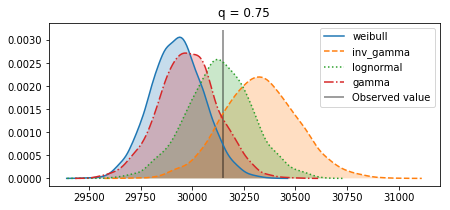

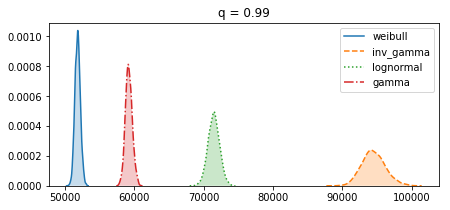

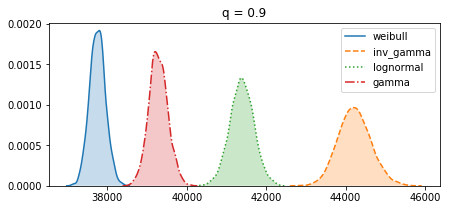

In [13]:
def kde_plot(X_preds, q, vlines=True):
    linestyles = ['-', '--', ':', '-.']
    for i, q_ in enumerate(q):
        fig, ax = plt.subplots(1,1,figsize=(7,3))
        for j, (model_name, Xs) in enumerate(X_preds.items()):
            X = Xs[:, i]
            sns.kdeplot(X, shade=True, label=model_name, ax=ax, linestyle=linestyles[j])
        if vlines:
            ax.vlines(data.loc[ind, str(int(q_*100))],
                      *ax.get_ylim(), 
                      color="black", 
                      alpha=0.5, 
                      label="Observed value")
        ax.set_title('q = {}'.format(q_))
        ax.legend()
    plt.show()
    
kde_plot(X_preds, q)
kde_plot(X_preds_unknown_q, q_unknown, vlines=False)

## earnings of the top 1%

In [14]:
param_names_dict = {
    'weibull': ['shape', 'scale'],
    'lognormal': ['mu', 'sigma'],
    'gamma': ['shape', 'rate'],
    'inv_gamma': ['shape', 'scale'],
}

q = np.array([0.25, 0.5, 0.75])

top_1_percent = OrderedDict() 
q_top_1_percent = np.array([0.99]) # only one element allowed
for ind, model_name in best_fit.items():
    N = data_normalized.loc[ind, 'N']
    X = np.array([data_normalized.loc[ind, q_] for q_ in ['25', '50', '75']])
    data_dict = {'N':N, 'M':len(q), 'q':q, 'X':X}
    
    stan_samples = models[model_name].sampling(data_dict) 
    
    param_names = param_names_dict[model_name]
    thetas = np.array([stan_samples.extract(p)[p] for p in param_names])
    values = np.array([get_quantiles(F_inv, theta, q_top_1_percent, model_name) 
                                    for theta in thetas.T]).squeeze()*data.loc[ind, '50']
    value_5_50_95 = list(np.percentile(values, [5, 50, 95]))
    top_1_percent[ind] = value_5_50_95

In [15]:
def tex_field(value_5_50_95): 
    low, mid, up = value_5_50_95.values
    return to_tex_field(mid, up-mid, low-mid) 

tmp = pd.DataFrame(top_1_percent, index=[5, 50, 95])
display(tmp)
top1 = (tmp.T.apply(tex_field, axis=1))

,UK,EL,ES,FR,IT,SE,LU,NL
5,70133.889220,22870.471843,43734.977945,58458.450187,40650.668198,53201.509855,112822.513095,61117.495891
50,71469.368533,23253.355626,44356.759833,59302.695610,41100.507175,53920.805478,115670.797679,62251.447026
95,72809.250249,23643.328015,44995.208779,60169.807642,41587.282358,54696.316807,118513.360774,63418.652128


In [16]:
joined = pd.concat((pd.Series(best_fit), top1), axis=1)
joined.columns = ['best model', '99% quantile']

joined

,best model,99% quantile
UK,lognormal,$71469.4^{\ +1339.9}_{\ -1335.5}$
EL,gamma,$23253.4^{\ +390.0}_{\ -382.9}$
ES,gamma,$44356.8^{\ +638.4}_{\ -621.8}$
FR,lognormal,$59302.7^{\ +867.1}_{\ -844.2}$
IT,weibull,$41100.5^{\ +486.8}_{\ -449.8}$
SE,weibull,$53920.8^{\ +775.5}_{\ -719.3}$
LU,lognormal,$115670.8^{\ +2842.6}_{\ -2848.3}$
NL,lognormal,$62251.4^{\ +1167.2}_{\ -1134.0}$
